In [1]:
!pip install brian2 matplotlib numpy neurodynex3

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 13.2 MB/s  0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ------------------------------- -------- 6.0/7.6 MB 30.8 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 26.3 MB/s  0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ----- ---------------------------------- 6.0/46.2 MB 30.7 MB/s eta 0:00:02
   ---------- ----------------------------- 11.8/46.2 MB 28.4 MB/s eta 0:00:02
   -------------- ------------------------- 16.5/46.2 MB 26.6 MB/s eta 0:00:02
   ------------------- -------------------- 22.0/46.2 MB 26.8 MB/s eta 0:00:01
   ----------------------- ---------------- 27.5/46.2 MB 26.8 MB/s eta 0:00:01
   ----------------------------- ---------- 33.8/46.2 MB 27.2 MB/s eta 0:00:01
   --------------------

In [21]:
import brian2 as b2
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate

In [ ]:
I_min = (LIF.FIRING_THRESHOLD - LIF.V_REST) / LIF.MEMBRANE_RESISTANCE

# create a step current with amplitude = I_min
step_current = input_factory.get_step_current(
    t_start=5, t_end=100, unit_time=b2.ms,
    amplitude=I_min)  # set I_min to your value

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 100 * b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)
print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0

In [ ]:
rates = []

for i in range(0, 100):
    step_current = input_factory.get_step_current(
        t_start=0, t_end=500, unit_time=b2.ms,
        amplitude=i * b2.namp)

    (state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 500 * b2.ms, abs_refractory_period=3 * b2.ms)
    
    rates.append(spike_monitor.count[0])

simulation_time_s = 0.5  # 500 ms = 0.5 s
firing_rates = [count / simulation_time_s for count in rates]

plt.figure(figsize=(8, 5))
plt.plot(range(0, 100), firing_rates, marker='o')
plt.xlabel("Input current amplitude (arbitrary units)")
plt.ylabel("Firing rate (Hz)")
plt.title("Firing rate vs Input current amplitude")
plt.grid(True)
plt.show()

In [15]:
# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=0, t_end=50, unit_time=b2.ms, amplitude=5.55 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# v_rest = -60 mV
# v_reset = -68 mV
# firing_threshold = -16 mv
# membrane_resistance = 8 Mohm
# membrane_time_scale = 24 ms
# abs_refractory_period = 3 ms

# print the parameters to the console and compare with your estimates
LIF.print_obfuscated_parameters(random_parameters)

NameError: name 'plot_tools' is not defined

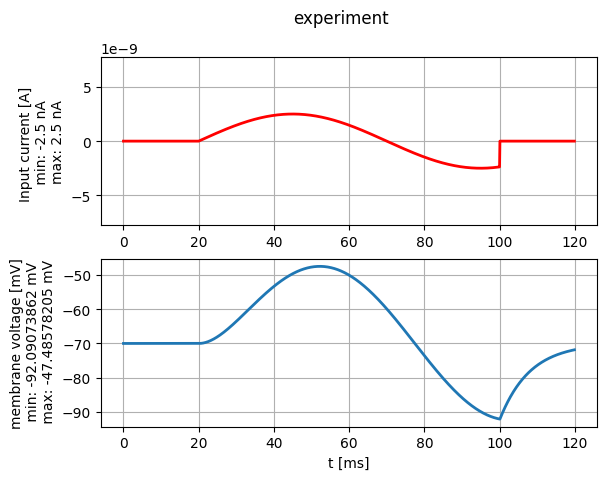

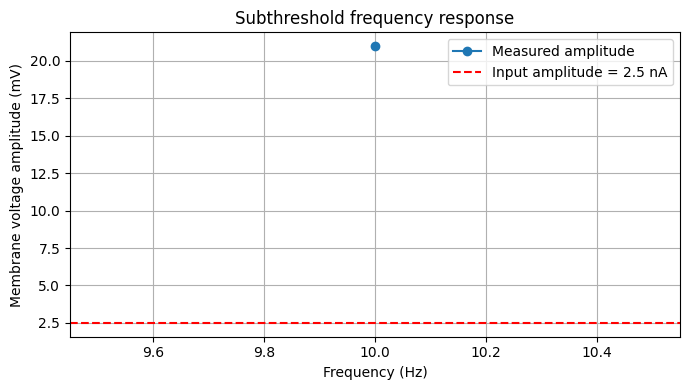

In [18]:
data = []

for f in range(10, 1001):
    # note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                                amplitude= 2.5 * b2.namp, frequency=f*b2.Hz,
                                                direct_current=0. * b2.namp)
    
    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

    
    v = state_monitor.v[0] / b2.mV  # convert to mV
    t = state_monitor.t / b2.ms      # convert to ms
    
    steady_state_mask = t > 60  # skip first 60 ms (half of 120 ms)
    v_ss = v[steady_state_mask]
    t_ss = t[steady_state_mask]

    v_max = np.max(v_ss)
    v_min = np.min(v_ss)
    amplitude = (v_max - v_min) / 2  # in mV

    data.append([f, amplitude])

# Convert to NumPy array for convenience
data = np.array(data)

# Split into frequency and amplitude arrays
freqs = data[:, 0]
amps = data[:, 1]

# Create the plot
plt.figure(figsize=(7, 4))
plt.plot(freqs, amps, marker='o', label='Measured amplitude')

# Add horizontal reference line at amplitude = 2.5
plt.axhline(2.5, color='r', linestyle='--', label='Input amplitude = 2.5 nA')

# Labels and formatting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Membrane voltage amplitude (mV)')
plt.title('Subthreshold frequency response')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

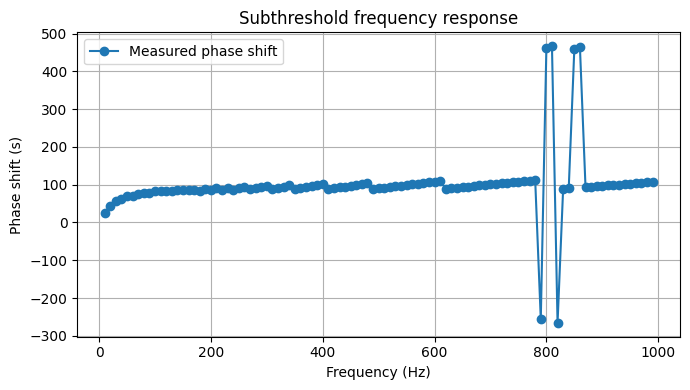

In [26]:
frequencies = range(10, 1000, 10)
data = []

for f in frequencies:
    # Generate sinusoidal current input
    sinusoidal_current = input_factory.get_sinusoidal_current(
        200, 1000, unit_time=0.1 * b2.ms,
        amplitude=2.5 * b2.namp, frequency=f * b2.Hz,
        direct_current=0. * b2.namp
    )
    
    # Run LIF simulation in subthreshold regime
    state_monitor, spike_monitor = LIF.simulate_LIF_neuron(
        input_current=sinusoidal_current,
        simulation_time=120 * b2.ms,
        firing_threshold=0 * b2.mV
    )
    
    # --- Extract current and voltage signals ---
    I = sinusoidal_current.values.flatten() / b2.namp
    V = (state_monitor.v[0] / b2.mV).flatten()
    t = np.arange(len(I)) * 0.1  # ms (since unit_time = 0.1 ms)

    # --- Remove mean (to avoid DC bias in correlation) ---
    I_centered = I - np.mean(I)
    V_centered = V - np.mean(V)
    
    # --- Cross-correlation ---
    corr = correlate(V_centered, I_centered, mode='full')
    lags = np.arange(-len(I)+1, len(I)) * 0.1  # lag values in ms
    
    # --- Find lag of maximum correlation ---
    best_lag_ms = lags[np.argmax(corr)]
    
    # --- Convert to phase shift (radians and degrees) ---
    lag_seconds = best_lag_ms * 1e-3
    phase_radians = 2 * np.pi * f * lag_seconds
    phase_degrees = np.degrees(phase_radians)

    # --- Store result ---
    data.append([f, phase_degrees])

# Convert to NumPy array for convenience
data = np.array(data)

# Split into frequency and amplitude arrays
freqs = data[:, 0]
amps = data[:, 1]

# Create the plot
plt.figure(figsize=(7, 4))
plt.plot(freqs, amps, marker='o', label='Measured phase shift')

# Labels and formatting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase shift (s)')
plt.title('Subthreshold frequency response')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(<Axes: ylabel='Input current [A] \n min: -2.37764129 nA \nmax: 2.37764129 nA'>,
 <Axes: xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -70.48368633 mV\n max: -50. mV'>)

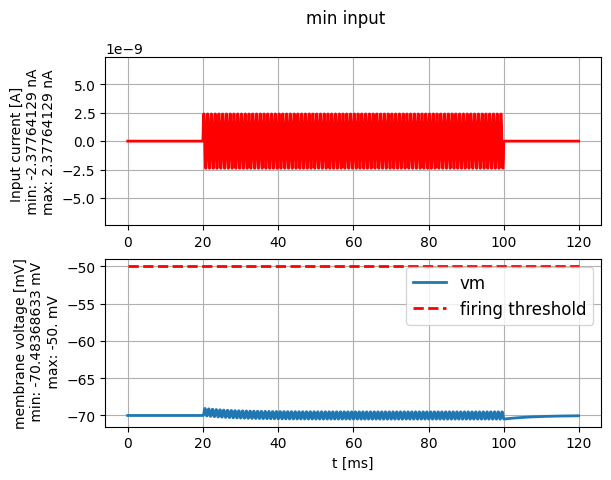

In [31]:

# Generate sinusoidal current input
sinusoidal_current = input_factory.get_sinusoidal_current(
    200, 1000, unit_time=0.1 * b2.ms,
    amplitude=2.5 * b2.namp, frequency=1000 * b2.Hz,
    direct_current=0. * b2.namp
)

# Run LIF simulation in subthreshold regime
state_monitor, spike_monitor = LIF.simulate_LIF_neuron(
    input_current=sinusoidal_current,
    simulation_time=120 * b2.ms,
    firing_threshold=0 * b2.mV
)

plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)